# TP1

# Exercicio 1a
O problema presente no execicio 1a é a implementação de uma comunicação cliente-servidor utilizando o package asyncio.
Para a implementação do execicio foram criados dois ficheiros python individuais, um para o receiver e outro para o emitter.

## Emitter
Para o emitter o funcionamento passa por numa primeira fase abrir conecção ao servidor atráves de um ip e de uma porta que se encontram hardcoded.

<b>Utilização do emitter:</b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ python3 emitter.py chave
</pre>

Se a ligação for estabelicida então o emitter entra em um modo de envio de mensagens onde é possivel inserir no terminal a mensagem a ser enviada para o servidor, caso contrario é apresentado um erro no terminal que indica que a ligação não foi estabelecida.

<b> Enviar mensagem: </b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ [CLIENT] Enviar mensagem para o servidor: inserir mensagem
</pre>

Assim que uma mensagem é enviada pelo emitter, imediatamente a seguir ele aguarda pela resposta do servidor.

## Receiver
Para o receiver o funcionamento passa por começar o serviço no ip e porta que se encontram hardcoded, ficando a servir por tempo ilimitado. O servidor suporta multiplos clientes e responde a cada um de forma individual.

Quando o servidor recebe uma mensagem de um cliente ele exibe no terminal a mensagem recebida com as informações do cliente, e envia como resposta exatamente a mesma mensagem que foi recebida.
Se o cliente fechar a comunicação o servidor continua a servir no mesmo ip/porta e aguarda por novos clientes.
Utilização do emitter:

<b>Utilização do receiver:</b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ python3 emitter.py chave
</pre>

<b>Nota:</b> Na secção do exercicio 1c encontra-se explicado como foi realizada a integração com os serviços de KDF e AEAD e as modificações realizadas no emitter e receiver.



# Exercicio 1b
Para o exercicio 1b pretende-se implementar uma cifra AEAD utilizando o shake-256 em modo XOFHash.

Para a resolução deste execicio foi criado o ficheiro AEAD.py que contém a implementação da cifra em uma classe.
 
O modelo sponge utilizado para implementar a cifra AEAD foi o seguinte

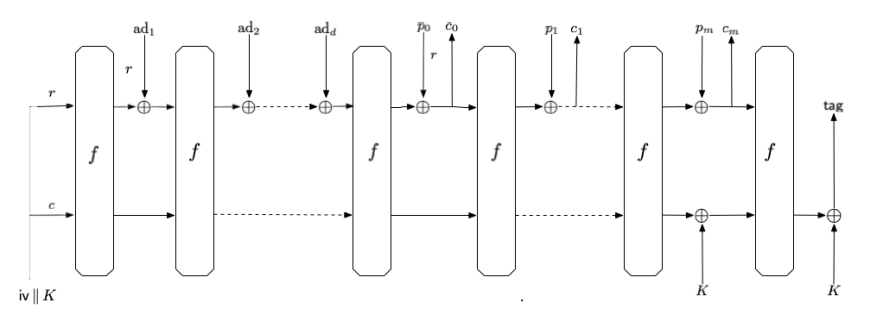

Neste modelo o rate é um IV, ou seja, um nounce gerado aleatoriamente. 

A capacidade do modelo é a chave, em que metade dos bits da chave são o coeficiente de segurança.

## Absorve
A fase de absorve funciona da seguinte forma:

O primeiro passo que é executado pelo sponge é a concatenação do rate da capacidade formando o estado da cifra, esse estado é passado pela função f (shake-256) que irá fornecer como output uma hash.

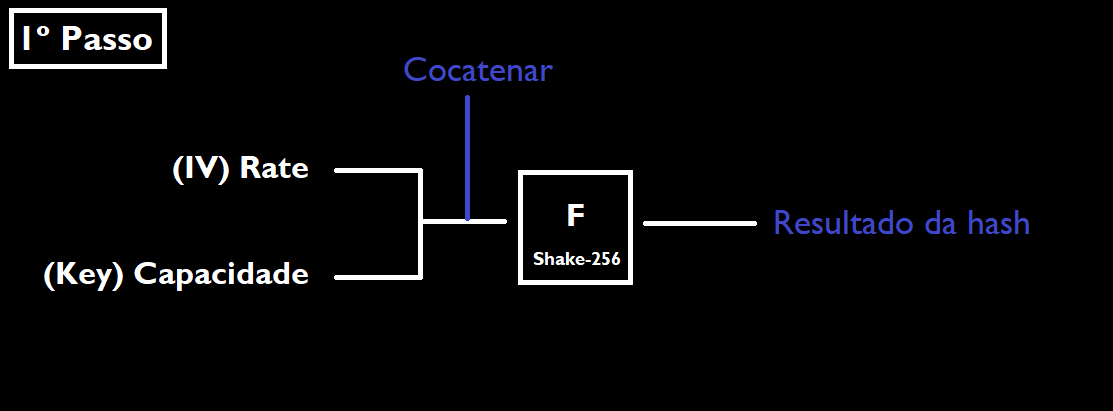

A partir dos primeiros rate bits do estado obtido após a aplicação da função F, é possível extrair um novo rate.

Com esse novo rate, é realizado um OTP (One-Time Pad) com um bloco de rate bits do Associated Data (AD). Para garantir que todo o AD possa ser dividido em blocos de tamanho igual ao rate, este passa por um processo de padding adequado.

Os blocos do AD precisam ter exatamente o tamanho do rate, pois cada um deles será combinado com o rate através do OTP. Durante esse processo, a capacidade (capacity) do estado permanece inalterada.

Após a aplicação do OTP entre o plaintext e o rate, o resultado é concatenado à capacidade, formando assim um novo estado. Esse estado é então submetido novamente à aplicação da função F, gerando um novo valor de hash.

Este processo repete-se iterativamente para cada bloco do Associated Data, garantindo que toda a informação seja incorporada de forma consistente no estado do sponge function.

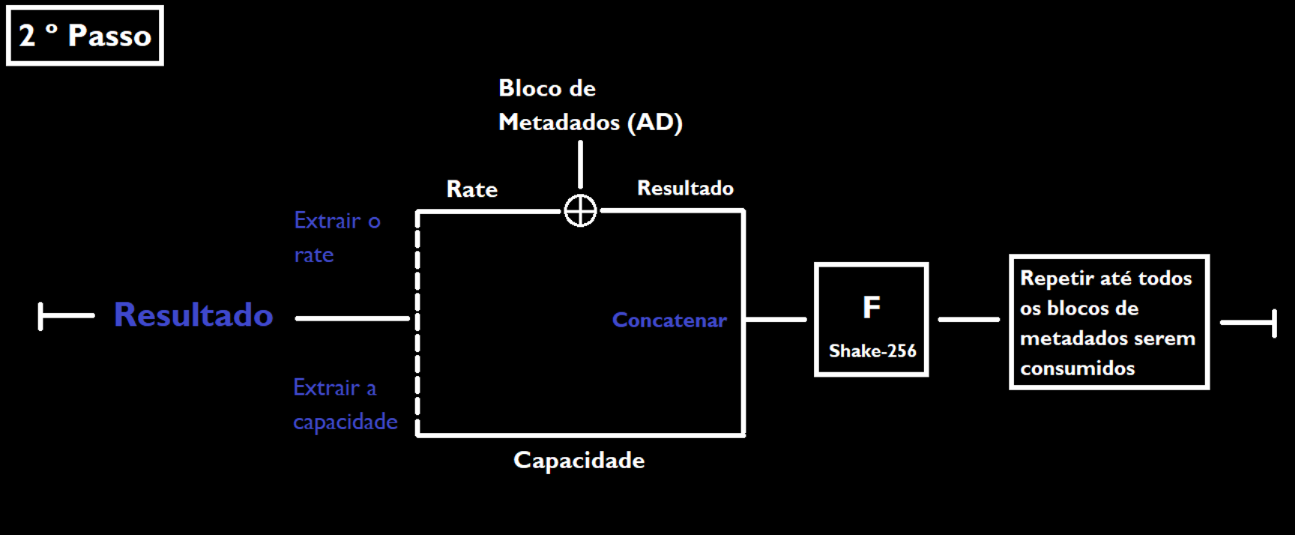


## Squeeze
A fase de squeeze ocorre da seguinte forma:

Inicialmente, o plaintext passa por um processo de padding para garantir que possa ser dividido em blocos de tamanho rate.

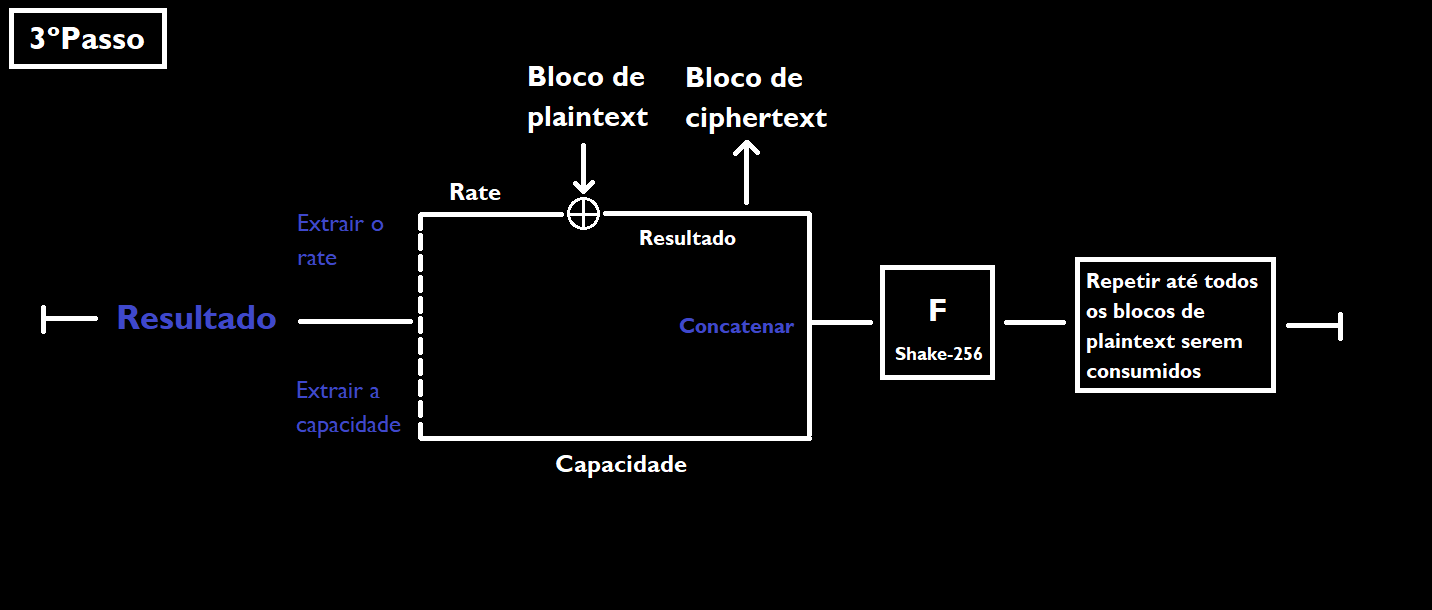

A partir do estado, são extraídos o rate e a capacidade. O rate é então combinado com um bloco do plaintext através de um OTP (One-Time Pad), cujo resultado constitui o primeiro bloco do ciphertext. Em seguida, o rate e a capacidade são concatenados, e a função F é aplicada ao novo estado.

Este processo é repetido para todos os blocos do plaintext, com exceção do último, onde ocorre uma modificação específica, que será explicada a seguir. Assim, os blocos do ciphertext vão sendo extraídos iterativamente.

Na última iteração do squeeze, a capacidade sofre uma operação OTP (One-Time Pad) com a chave (key), e o resultado passa a ser a nova capacidade. Em seguida, esta nova capacidade é concatenada com o rate, e a função F é aplicada novamente para finalizar o processo.

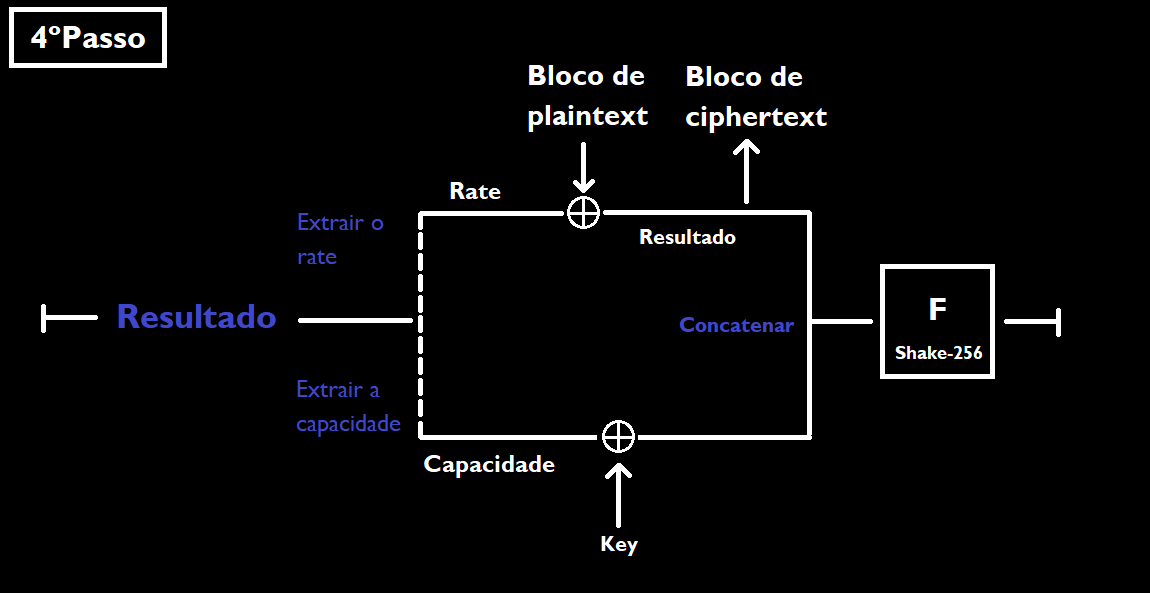

## Geração da tag
Para gerar a tag é realizado uma operação OTP (One-Time Pad) entre o resultado do squeeze e a key.

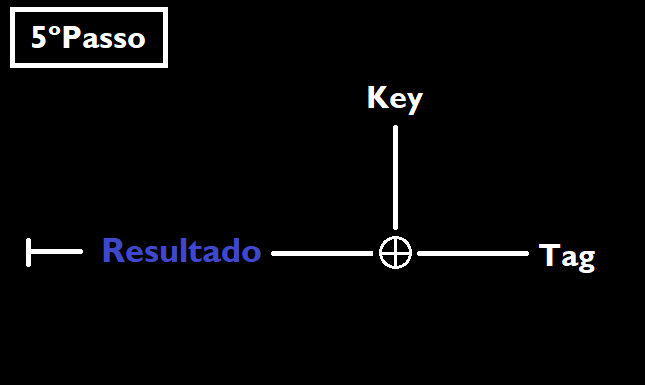

## Padding do plaintext e associated data
Implementámos dois tipos de padding: PKCS7 e Zero Padding. 

O tipo de padding a ser utilizado pode ser selecionado conforme necessário.

### PKCS7
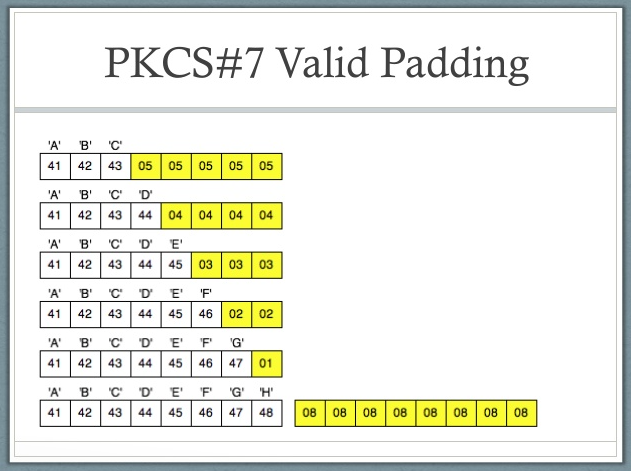

O PKCS7 cria um padding que faz com que o input seja multiplo do tamanho de um bloco, o que é uma propriedade util para o contexto da implementação do sponge.

O PCKS7 adiciona bytes de padding que indicam quantos bytes foram inseridos, o que permite uma remoção fácil do padding.

No entanto a vantagem do pkcs7 mais importante é que ele permite detetar corrupção ou modificação dos dados, isto porque, se os dados forem truncados é possivel detetar.

Ou seja este padding é seguro e permite descobrir no processo de decifragem se os dados foram modificados sem a necessidade de verificar as tags de cifragem e decifragem. 

No entanto não remove a necessidade da comparação de tags, apenas fornece uma segurança extra que é util. 

### Zero Padding
Com o zero padding é inserido um bit 1 no final do texto e são adicionados bits 0 até que o tamanho pretendido seja obtido.

Para a remoção do padding é realizado uma procura apartir da ultima posição do texto e assim que é encontrado o bit 1 ocorre a remoção de todo o padding.

# Decifragem
Na decifragem, replicam-se todos os estados obtidos durante a cifragem, com apenas uma diferença na fase de squeeze.

A fase de absorção ocorre exatamente como na cifragem. Entretanto, na fase de squeeze, em vez de realizar o OTP com blocos do plaintext, utiliza-se os blocos do ciphertext. Esses blocos de ciphertext são então concatenados à capacidade para formar um estado equivalente ao da cifragem, uma vez que a função de hash é determinística. 

Para gerar a tag, é efetuado um OTP entre o último estado e a chave. Como o último estado da decifragem deve ser equivalente ao último estado da cifragem, o valor da tag decifrada deverá ser idêntico ao da tag cifrada, a menos que o ciphertext tenha sido modificado.


## Exercicio 1c

**Enunciado 1c:** As chaves de cifra e os nonces são gerados por um gerador KDF, sendo que as diferentes chaves de inicialização do KDF são fornecidas como inputs pelo emissor e pelo receptor.

Nesta etapa do trabalho, tanto o emitter quanto o receiver receberão, como parâmetro de execução, uma chave. Essa chave servirá como material inicial para gerar, por meio de um KDF, a chave de cifra e o nonce que serão utilizados na comunicação entre os dois agentes.

Para a geração desses elementos, foi utilizado um Key Derivation Function (KDF) – especificamente o HKDF. O HKDF é uma escolha segura porque utiliza HMAC, que possui fortes propriedades de pseudoaleatoriedade e resistência a ataques de colisão, e permite estender o material de entrada para qualquer comprimento desejado de forma determinística. Foi criado um ficheiro Python (kdf.py) que implementa esse KDF. A função KDF recebe como parâmetros: uma chave, o comprimento de saída, o salt e o info.

Como o emissor e o receptor precisam gerar exatamente a mesma chave para que possam decifrar as mensagens um do outro, foram definidos valores hardcoded idênticos para a chave, salt, comprimento e info em ambos os lados, garantindo que a chave derivada seja equivalente.

Para gerar o nonce, utiliza-se a mesma chave, comprimento e info, mas com um salt diferente, de forma a gerar um valor distinto. Esse salt utilizado para gerar o nonce pode ser configurado separadamente no emitter e no receiver.

Além disso, o emitter e o receiver permitem a personalização de outros parâmetros, tais como o tipo de padding utilizado pelo AEAD e o modo de debug, que possibilita visualizar no terminal detalhes do funcionamento do programa (como as tags, ciphertexts e outros detalhes de implementação).

Na implementação deste exercício, os ficheiros emitter.py e receiver.py foram modificados para utilizar o AEAD desenvolvido no exercício 1b.

**No emitter:** Quando o emitter inicia, ele gera uma chave e o nonce utilizando o KDF. Antes de enviar uma mensagem para o servidor, a mensagem é cifrada utilizando o AEAD. Em seguida, o emitter aguarda a resposta do servidor e, ao recebê-la, realiza a decifragem.

**No receiver:** Ao estabelecer conexão com um novo cliente, o receiver gera a chave e o nonce. Ao receber uma mensagem, o receiver decifra a mensagem utilizando o AEAD. 
Após receber a mensagem do cliente, o receiver envia uma mensagem idêntica à recebida, cifrando-a novamente com o AEAD.

Esta abordagem garante que, ao usar as mesmas chaves de seed, ambos os lados gerem chaves idênticas utilizando o KDF, permitindo uma comunicação privada, segura e sincronizada entre o emissor (emitter) e o receptor (receiver).

# Codigo desenvolvido:

## Receiver.py


In [ ]:
# Estruturas criptográficas 2024-2025
# Grupo 02 - Miguel Ângelo Martins Guimarães (pg55986) e Pedro Miguel Oliveira Carvalho (pg55997)

# Este ficheiro contem o codigo da aplicação servidor

# Bibliotecas
import asyncio
import sys
import kdf
import AEAD

#########################################################################################
# Valores hardcoded alteráveis
server_ip = 'localhost'
server_port = 2003

# Modo debug
view_tags = False # Permite visualizar o valor das tags
view_cyphertexts = False # Permite visualizar o valor dos ciphertexts
view_details = True # Informacoes extra sobre o funcionamento 

# Informações para derivação de chaves (Segredos partilhados entre o emmiter e receiver)
SALT = b"salt-fixo-para-utilizar"
INFO_KEY = b"info-chave"
GEN_KEY_SIZE = 30
ASSOCIATED_DATA = "associated-data"

# Pode ser modificado
INFO_NONCE = b"info-nonce"
padding_mode = "pkcs" # Modos explicados abaixo (Tem de ser equivalente de ambos os lados)

# Valores possiveis para o padding_mode:
#  pkcs - Permite deteção de modificação da mensagem no recetor da mensagem) 
#  zero - Utiliza zero-padding em que apenas se consegue verificar a tag comparando as tags de cifragem e decifragem    
#########################################################################################

# Lidar com uma mensagen recebida
async def recMsg(reader, writer):
    # Instanciar AEAD
    aead_cipher = AEAD.aead()

    # Obter a chave
    shared_key = sys.argv[1]
    shared_key_bytes = shared_key.encode()

    # Gerar a key
    aead_key = kdf.derive_key(shared_key_bytes, GEN_KEY_SIZE, SALT, INFO_KEY)
    print("[RECEIVER] Chave gerada.")
    aead_nounce = kdf.derive_key(shared_key_bytes, GEN_KEY_SIZE, SALT, INFO_NONCE)
    print("[RECEIVER] Nounce gerado.")

    # Receber comunicação do cliente
    addr = writer.get_extra_info('peername')
    print(f"[RECEIVER] Conexão estabelecida com {addr!r}")

    # Receber mensagens
    while True:
        data = await reader.read(100) # Esperar por mensagem
    
        if not data:
            break  # Coneccao do cliente desligada

        # Modo debug
        if(view_cyphertexts):
            print(f"[RECEIVER-DEBUG] Ciphertext recebido: {data}")

        originaltext_bytes, decrypt_tag = aead_cipher.decrypt(data, ASSOCIATED_DATA, aead_key, padding_mode)
        originaltext = originaltext_bytes.decode() # Passar o plaintext para texto
        print(f"[RECEIVER] Mensagem decifrada: {originaltext!r} enviada por {addr!r}.")

        # Visualizar a tag caso necessário
        if(view_tags):
            print(f"[RECEIVER-DEBUG] Tag da mensagem decifrada: {decrypt_tag!r} enviada por {addr!r}.")

        # Enviar a mesma mensagem de volta
        ciphertext_send, encrypt_tag = aead_cipher.encrypt(originaltext, ASSOCIATED_DATA, aead_key, aead_nounce, padding_mode)
        print(f"[RECEIVER] Mensagem espelhada enviada (automático): {originaltext!r}")
        writer.write(data)
        await writer.drain()

        # Modo debug
        if(view_cyphertexts):
            print(f"[RECEIVER-DEBUG] Ciphertext enviado: {ciphertext_send}")
        if(view_tags):
            print(f"[RECEIVER-DEBUG] Tag da mensagem enviada: {encrypt_tag}")

    print(f"[RECEIVER] Conexão fechada com {addr!r}")
    writer.close()
    await writer.wait_closed()

async def main():
    # Verificar se a chave foi recebida como argumento
    if len(sys.argv) < 2:
        print("[RECEIVER] Erro: Chave em falta!")
        print("[RECEIVER] Uso: python receiver.py <chave>")
        print("[RECEIVER] Nota: Recomenda-se utilizar a mesma chave para o servidor e o cliente.")
        sys.exit(1)

    # Iniciar o servidor
    print("[RECEIVER] Aplicacao servidor iniciada.")
    
    # Modo debug
    if(view_details):
        print("[RECEIVER-DEBUG] Modo de padding: " + str(padding_mode) + ", tamanho da chave gerada: " + str(GEN_KEY_SIZE) + '.')

    # Iniciar o servidor
    server = await asyncio.start_server(recMsg, server_ip, server_port)

    addrs = ', '.join(str(sock.getsockname()) for sock in server.sockets)
    print(f'[RECEIVER] A servir em {addrs}')

    async with server:
        await server.serve_forever()

asyncio.run(main())


## Emitter.py

In [ ]:
# Estruturas criptográficas 2024-2025
# Grupo 02 - Miguel Ângelo Martins Guimarães (pg55986) e Pedro Miguel Oliveira Carvalho (pg55997)

# Este ficheiro contem o codigo da aplicação cliente

# Bibliotecas
import asyncio
import sys
import kdf
import AEAD

#########################################################################################
# Valores hardcoded alteráveis
server_ip = 'localhost'
server_port = 2003

# Modo debug
view_tags = False # Permite visualizar o valor das tags
view_cyphertexts = False # Permite visualizar o valor dos ciphertexts
view_details = True # Informacoes extra sobre o funcionamento 

# Informações para derivação de chaves (Segredos partilhados entre o emmiter e receiver) 
# (Tem de ser equivalente de ambos os lados)
SALT = b"salt-fixo-para-utilizar"
INFO_KEY = b"info-chave"
GEN_KEY_SIZE = 30
ASSOCIATED_DATA = "associated-data"

# Pode ser modificado
INFO_NONCE = b"info-nonce"
padding_mode = "pkcs" # Modos explicados abaixo (Tem de ser equivalente de ambos os lados)

# Valores possiveis para o padding_mode:
#  pkcs - Permite deteção de modificação da mensagem no recetor da mensagem) 
#  zero - Utiliza zero-padding em que apenas se consegue verificar a tag comparando as tags de cifragem e decifragem     
#########################################################################################


# Enviar mensagem para o servidor
async def sendMsg(aead_cipher, writer, reader, message, aead_key, aead_nounce):
    try:
        print(f'[CLIENT] A enviar: {message!r}')
        
        # Realizar encrypt da mensagem
        ciphertext_send, encrypt_tag = aead_cipher.encrypt(message, ASSOCIATED_DATA, aead_key, aead_nounce, padding_mode)
        
        # Modo debug
        if(view_cyphertexts):
            print(f"[RECEIVER-DEBUG] Ciphertext enviado: {ciphertext_send}")
        if(view_tags):
            print(f"[RECEIVER-DEBUG] Tag da mensagem enviada: {encrypt_tag}")

        # Enviar a mensagem cifrada para o servidor
        writer.write(ciphertext_send)

        await writer.drain()
        print('[CLIENT] Mensagem cifrada enviada com sucesso.')

        data = await reader.read(100)
        originaltext, decrypt_tag = aead_cipher.decrypt(data, ASSOCIATED_DATA, aead_key, padding_mode)
        print(f'[CLIENT] Recebido: {originaltext.decode()}')

        # Modo debug
        if(view_cyphertexts):
            print(f"[RECEIVER-DEBUG] Ciphertext recebido: {data}")
        if(view_tags):
            print(f"[RECEIVER-DEBUG] Tag da mensagem enviada: {decrypt_tag}")

    except Exception as e:
        print(f"[CLIENT] Erro ao enviar ou receber mensagem: {e}")

# Função principal
async def main():
    print("[CLIENT] Aplicacao cliente iniciada.")
    
    # Modo debug
    if(view_details):
        print("[RECEIVER-DEBUG] Modo de padding: " + str(padding_mode) + ", tamanho da chave gerada: " + str(GEN_KEY_SIZE) + '.')

    # Instanciar AEAD
    aead_cipher = AEAD.aead()

    # Verificar se a chave foi recebida como argumento
    if len(sys.argv) < 2:
        print("[CLIENT] Erro: Chave em falta!")
        print("[CLIENT] Uso: python emmiter.py <chave>")
        print("[CLIENT] Nota: Recomenda-se utilizar a mesma chave para o servidor e o cliente.")
        sys.exit(1)

    # Chave recebida como argumento
    shared_key = sys.argv[1]
    shared_key_bytes = shared_key.encode()

    # Gerar a key
    aead_key = kdf.derive_key(shared_key_bytes, GEN_KEY_SIZE, SALT, INFO_KEY); print("[CLIENT] Chave gerada.")
    aead_nounce = kdf.derive_key(shared_key_bytes, GEN_KEY_SIZE, SALT, INFO_NONCE); print("[CLIENT] Nounce gerado.")

    try:
        # Iniciar o cliente
        print("[CLIENT] A conectar ao servidor.")
        reader, writer = await asyncio.open_connection(server_ip, server_port)
        print(f"[CLIENT] Conexão ao servidor (ip:{server_ip}, porta:{server_port}) estabelecida.")

        # Cliente a correr
        while True:
            msg_data = input("[CLIENT] Enviar mensagem para o servidor: ")
            await sendMsg(aead_cipher, writer, reader, msg_data, aead_key, aead_nounce)
            
    except ConnectionRefusedError:
        print("[CLIENT] Erro: Nao foi possivel conectar ao servidor.")
        print("[CLIENT] Causas possiveis: Servidor desligado ou porta incorreta.")
    except Exception as e:
        print(f"[CLIENT] Erro inesperado: {e}")
    finally:
        if 'writer' in locals():
            writer.close()
            await writer.wait_closed()

# Iniciar a aplicação
asyncio.run(main())


## kdf.py

In [ ]:
# Estruturas criptográficas 2024-2025
# Grupo 02 - Miguel Ângelo Martins Guimarães (pg55986) e Pedro Miguel Oliveira Carvalho (pg55997)

# Imports
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes

# Função que cria deriva uma chave utilizando o algoritmo HKDF com hash SHA256
def derive_key(master_key: bytes, length: int, salt: bytes, info: bytes) -> bytes:
    # Verificações
    if not master_key:
        raise ValueError("A chave não pode estar vazia.")
    if not salt:
        raise ValueError("O salt não pode estar vazio.")
    if not info:
        raise ValueError("O info não pode estar vazio.")

    # Advertir caso a chave seja demasiado pequena
    if len(master_key) < 16:
        print("[KDF] Aviso: A chave tem menos de 16 bytes. Entropia insuficiente para derivar uma chave segura.")

    # O HKDF já estende a chave de forma determinística para o tamanho desejado
    hkdf = HKDF(
        algorithm=hashes.SHA256(),
        length=length,
        salt=salt,
        info=info,
    )
    return hkdf.derive(master_key)

## AEAD.py

In [ ]:
# Estruturas criptográficas 2024-2025
# Grupo 02 - Miguel Ângelo Martins Guimarães (pg55986) e Pedro Miguel Oliveira Carvalho (pg55997)

# Imports
import sys
import secrets
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import padding

#############################################
# Valores alteraveis (hardcoded)
NOUNCESIZE = 16 # Tamanho do nounce default
#############################################

# Classe que contém o codigo da cifra aead (Tipos de padding: zero ou pkcs) 
# Utiliza zero padding por default
class aead:
    # A cifra vai receber a mensagem (plaintext), dados associados (ad), uma chave (key)
    def encrypt(self, plaintext="", ad="", key_bytes=b'', iv=None, paddingType="zero"):
        # Se não for passado um IV, é gerado um nonce default
        if iv is None:
            iv = secrets.token_bytes(NOUNCESIZE)

        # Verificação do input
        self._checkdata(plaintext, ad, key_bytes)

        # Preparação das variaveis
        plaintext_bytes = plaintext.encode() 
        ad_bytes = ad.encode() 
        blockSize = len(iv) # Tamanho do bloco

        # Preparação (Adicionar padding)
        ad_padded = b''
        plaintext_padded = b''
        if (paddingType == "zero"):
            ad_padded = self.__AddPaddingZero(ad_bytes, blockSize) 
            plaintext_padded = self.__AddPaddingZero(plaintext_bytes, blockSize)
        elif (paddingType == "pkcs"):
            ad_padded = self.__AddPaddingPKCS(ad_bytes, blockSize) 
            plaintext_padded = self.__AddPaddingPKCS(plaintext_bytes, blockSize)
        else:
            raise ValueError("[AEAD] Tipo de padding desconhecido.")

        # Execução do algoritmo de cifragem
        absorve_state = self.__absorve(iv, key_bytes, ad_padded) # Realizar o absorve
        result = self.__squeeze(plaintext_padded, absorve_state, blockSize, key_bytes, mode="encrypt")

        # Cria um campo de 2 bytes com o tamanho do nonce
        nonce_length = len(iv).to_bytes(2, byteorder="big")

        # Resultado concatenado: [tamanho do nonce][nonce][ciphertext]
        return nonce_length + iv + result[0], result[1]

    # A cifra vai receber a mensagem (ciphertext), dados associados (ad), uma chave (key)
    def decrypt(self, ciphertext_bytes=b'', ad="", key_bytes=b'', paddingType="zero"):
        # Extrair os primeiros 2 bytes para obter o tamanho do nonce
        nonce_length = int.from_bytes(ciphertext_bytes[:2], byteorder="big")

        # Extrair o nonce
        iv = ciphertext_bytes[2:2+nonce_length]
        
        # Extrair o ciphertext
        ciphertext_bytes = ciphertext_bytes[2+nonce_length:]

        # Verificação do input
        self._checkdata(ciphertext_bytes, ad, key_bytes)

        # Preparação das variaveis
        ad_bytes = ad.encode() 
        blockSize = len(iv)

        # Preparação (Adicionar padding)
        ad_padded = b''
        if (paddingType == "zero"):
            ad_padded = self.__AddPaddingZero(ad_bytes, blockSize)
        elif (paddingType == "pkcs"):
            ad_padded = self.__AddPaddingPKCS(ad_bytes, blockSize)
        else:
            raise ValueError("Tipo de padding desconhecido.")

        # Execução do algoritmo de cifragem
        absorve_state = self.__absorve(iv, key_bytes, ad_padded) # Realizar o absorve
        plaintext_padded, tag = self.__squeeze(ciphertext_bytes, absorve_state, blockSize, key_bytes, mode="decrypt")

        # Remover o padding da cifragem
        unpadded_plaintext= b''
        if (paddingType == "zero"):
            unpadded_plaintext = self.__RemovePaddingZero(plaintext_padded, blockSize)
        elif (paddingType == "pkcs"):
            unpadded_plaintext = self.__RemovePaddingPKCS(plaintext_padded, blockSize)
        
        return unpadded_plaintext, tag

    # Método privado que adiciona padding a uma sequência de bytes (usando pkcs7) 
    # - Faz com que o tamanho do input seja multiplo do tamanho do bloco
    # - Permite detetar ataques de comprimento 
    # - Permite remoção fácil do padding. 
    def __AddPaddingPKCS(self, input: bytes, blockSize: int) -> bytes:
        padder = padding.PKCS7(blockSize * 8).padder() # So trabalha com bits o pkcs7
        padded = padder.update(input) + padder.finalize()
        return padded

    # Método privado que remove padding
    def __RemovePaddingPKCS(self, input_data: bytes, blockSize: int) -> bytes:
        unpadder = padding.PKCS7(blockSize * 8).unpadder()
        try:
            unpadded = unpadder.update(input_data) + unpadder.finalize()
        except ValueError as e:
            print("[AEAD] O algoritmo de padding PKCS7 detetou corrupção de dados.")
            sys.exit(1)  # Parar o algoritmo
        return unpadded

    # Metodo privado de zero padding
    def __AddPaddingZero(self, input_data: bytes, blockSize: int) -> bytes:
        remainder = len(input_data) % blockSize
        if remainder == 0:
            padding_size = blockSize
        else:
            padding_size = blockSize - remainder
        padding = b'\x01' + (b'\x00' * (padding_size - 1))
        return input_data + padding

    # Metodo privado de remoção de zero padding
    def __RemovePaddingZero(self, input_data: bytes, blockSize: int) -> bytes:
        if not input_data:
            raise ValueError("[Padding] Erro: Dados vazios.")
        last_padding_index = input_data.rfind(b'\x01') # Procurar pelo bit de inicio de padding apartir do lado direito
        if last_padding_index == -1 or last_padding_index < len(input_data) - blockSize:
            raise ValueError("[Padding] Erro: Padding inválido ou corrompido.")
        return input_data[:last_padding_index] # Extrair todos os bytes até ao bit de inicio do padding

    # Metodo privado que realiza o absorve do sponge (Devolve o ultimo estado)
    def __absorve(self, starting_rate, key_bytes, padded_data):
        # Preparação para o absorve
        ad = padded_data
        blockSize = len(starting_rate)
        cycles = int(len(padded_data) / blockSize) 
        state = starting_rate + key_bytes
        state_size = len(state)

        # Iterações do absorve
        for n in range(cycles):
            # Aplicar a função F (shake-256)
            digest = hashes.Hash(hashes.SHAKE256(digest_size=state_size))
            digest.update(state) # Dar como input o estado atual
            state = digest.finalize() # Receber o output que passa a ser o proximo estado

            # Preparação para o OTP
            new_rate = state[:blockSize] # Extrair os primeiros rate bits do estado (rate do estado atual)
            state    = state[blockSize:] # Remover os primeiros rate bits do estado (criar espaço para o resultado)
            block    = ad[:blockSize]    # Extrair os primeiros rate bits dos metadados (bloco de dados do ad)
            ad       = ad[blockSize:]    # Remover os primeiros rate bits dos metadados (para iterar o ad)

            # Aplicar OTP
            xor_result = bytes(x ^ y for x, y in zip(new_rate, block)) # Realizar 'rate XOR metadados'
            state = xor_result + state
        
        return state

    # Metodo privado que realiza o squeeze do sponge
    # input_data: O que vai sendo inserido ao longo do squeeze
    def __squeeze(self, input_data, state, blockSize, key_bytes, mode="encrypt"):
        extracted_data = b''  # Resultado do squeeze
        cycles = int(len(input_data) / blockSize)  # Número de iterações
        state_size = len(state)  # Tamanho do state

        # Iterações normais do squeeze
        for n in range(cycles):
            rate        = state[:blockSize]      # Extrair os primeiros rate bits do estado (rate do estado atual)
            state       = state[blockSize:]      # Remover os primeiros rate bits do estado (rate do estado atual)
            input_block = input_data[:blockSize] # Extrair um bloco do input_data (ciphertext ou plaintext)
            input_data  = input_data[blockSize:] # Remover um bloco do input_data

            # Calcular a saída (XOR entre rate e input_block)
            xor_result = bytes(x ^ y for x, y in zip(rate, input_block))
            extracted_data += xor_result

            # Atualização do state: (Vamos utilizar o ciphertext em ambos para os estados estarem sincronizados)
            if mode == "encrypt":
                state = xor_result + state # Ao fazer cifragem, o bloco usado é o xor_result (que é o ciphertext)
            else:
                state = input_block + state # Ao fazer decifragem, o bloco usado é o input_block (o ciphertext recebido)

            # Atualizar o state (SHAKE256)
            digest = hashes.Hash(hashes.SHAKE256(digest_size=state_size))
            digest.update(state)
            state = digest.finalize()

        # Processar a última iteração (key-mixing e tag)
        if cycles > 0:
            rate = state[:blockSize]             # Extrair os primeiros rate bits do estado (rate do estado atual)
            state = state[blockSize:]            # Remover os primeiros rate bits do estado (rate do estado atual)
            input_block = input_data[:blockSize] # Extrair um bloco do input_data (ciphertext ou plaintext)
            input_data = input_data[blockSize:]  # Remover um bloco do input_data

            xor_result = bytes(x ^ y for x, y in zip(rate, input_block))
            extracted_data += xor_result

            # Atualização do state: (Vamos utilizar o ciphertext em ambos para os estados estarem sincronizados)
            if mode == "encrypt":
                state = xor_result + state # Ao fazer cifragem, o bloco usado é o xor_result (que é o ciphertext)
            else:
                state = input_block + state # Ao fazer decifragem, o bloco usado é o input_block (o ciphertext recebido)

            # Atualizar o state (SHAKE256)
            digest = hashes.Hash(hashes.SHAKE256(digest_size=state_size))
            digest.update(state)
            state = digest.finalize()

        # A tag é gerada fazendo XOR final do state com a chave
        key_for_tag = (key_bytes * ((state_size // len(key_bytes)) + 1))[:state_size]
        tag = bytes(x ^ y for x, y in zip(state, key_for_tag))
        return extracted_data, tag

    # Metodo privado que verifica os dados recebidos
    def _checkdata(self, plaintext, ad, key_bytes):
        if not plaintext:
            raise ValueError("Erro: O `plaintext` não pode estar vazio.")
        if not ad:
            raise ValueError("Erro: O `ad` (Associated Data) não pode estar vazio.")
        if not key_bytes:
            raise ValueError("Erro: A `key` (chave) não pode estar vazia.")


# Bibliografia utilizada:
**Patra, A., & Sinha Roy, S. (Eds.). (2021).** *Progress in Cryptology – INDOCRYPT 2021: 22nd International Conference on Cryptology in India, Jaipur, India, December 12–15, 2021, Proceedings* (Vol. 13143). Springer.  
Disponível em: [https://doi.org/10.1007/978-3-030-92518-5](https://doi.org/10.1007/978-3-030-92518-5)

**Cryptography.io.** (n.d.). *SHAKE256*. Disponível em: [https://cryptography.io/en/latest/hazmat/primitives/cryptographic-hashes/#cryptography.hazmat.primitives.hashes.SHAKE256](https://cryptography.io/en/latest/hazmat/primitives/cryptographic-hashes/#cryptography.hazmat.primitives.hashes.SHAKE256)

**National Institute of Standards and Technology (NIST).** (2015). *FIPS 202: SHA-3 Standard: Permutation-Based Hash and Extendable-Output Functions*. Disponível em: [https://csrc.nist.gov/files/pubs/fips/202/final/docs/fips_202_draft.pdf](https://csrc.nist.gov/files/pubs/fips/202/final/docs/fips_202_draft.pdf)

**Keccak Team.** (n.d.). *The Sponge and Duplex Constructions*. Disponível em: [https://keccak.team/sponge_duplex.html](https://keccak.team/sponge_duplex.html)

**Coruus.** (n.d.). *py-keccak: FIPS202 Implementation*. GitHub Repository. Disponível em: [https://github.com/coruus/py-keccak/tree/master/fips202](https://github.com/coruus/py-keccak/tree/master/fips202)

**Cryptography.io.** (n.d.). *Symmetric Encryption*. Disponível em: [https://cryptography.io/en/latest/hazmat/primitives/symmetric-encryption/](https://cryptography.io/en/latest/hazmat/primitives/symmetric-encryption/)

**PyCryptodome.** (n.d.). *SHAKE256 Documentation*. Disponível em: [https://pycryptodome.readthedocs.io/en/latest/src/hash/shake256.html](https://pycryptodome.readthedocs.io/en/latest/src/hash/shake256.html)